### Import Comment

In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib
df = pd.read_csv('/home/spuccio/God-of-Words/df_merge.csv',sep="\t",header=0)
df

,sentiment_polarity_textblob,comment,sentiment_polarity_vader
0,0.225000,actually good unbelievable god like quote,0.8074
1,0.113636,positive energy one reason well going use tech...,0.7783
2,0.050000,harry weekend league every game go penalties w...,0.1027
3,0.392857,everton fan right swear quoted line fields anf...,0.7430
4,0.500000,know harry got top bronze team never mentions,0.2023
...,...,...,...
37486,0.100000,made pete look young,0.0000
37487,0.100000,finishers game amazing,0.5859
37488,-0.150000,jack really loud game,0.0000
37489,0.000000,energy converter generator,0.2732


In [2]:
df2 = df[['comment','sentiment_polarity_vader']].loc[(df['sentiment_polarity_vader'] >= 0.75) | (df['sentiment_polarity_vader'] <= -0.75) ]

In [3]:
df2['final_sentiment'] = np.where(df2['sentiment_polarity_vader'] > 0,"positive",np.where(df2['sentiment_polarity_vader']<0,"negative",1)) 

In [4]:
df2

,comment,sentiment_polarity_vader,final_sentiment
0,actually good unbelievable god like quote,0.8074,positive
1,positive energy one reason well going use tech...,0.7783,positive
11,really enjoy videos bro keep good grind harry ...,0.9516,positive
14,love celebrates comes bad team like already ke...,0.7845,positive
21,love basically adds vids id watch guy would ge...,0.7717,positive
...,...,...,...
37424,love excited gets graphics bc way,0.7650,positive
37429,petes eyes pitch black spider bite must infect...,-0.8779,negative
37444,love sound holograms make like ropt going aaa,0.7717,positive
37469,holy crap man loved video much wish game huge ...,0.9153,positive


In [5]:
from tqdm import tqdm
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

stop = [x.replace("'",'') for x in stop]

corpus = df2['comment'][~df2['comment'].isna()]
corpus = corpus.str.lower().str.replace('[^\w\s]','')
corpus = corpus.str.split()
corpus = corpus.apply(lambda x: [lemmatizer.lemmatize(item) for item in x if item not in stop])
corpus = corpus.apply(lambda x: [item for item in x if not item.isnumeric()])
corpus

[nltk_data] Downloading package wordnet to /home/spuccio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0         [actually, good, unbelievable, god, like, quote]
1        [positive, energy, one, reason, well, going, u...
11       [really, enjoy, video, bro, keep, good, grind,...
14       [love, celebrates, come, bad, team, like, alre...
21       [love, basically, add, vids, id, watch, guy, w...
                               ...                        
37424               [love, excited, get, graphic, bc, way]
37429    [petes, eye, pitch, black, spider, bite, must,...
37444    [love, sound, hologram, make, like, ropt, goin...
37469    [holy, crap, man, loved, video, much, wish, ga...
37476                            [make, happy, see, happy]
Name: comment, Length: 4711, dtype: object

In [6]:
#corpus.str.split()

In [7]:
from collections import Counter
c = Counter()
for sentence in corpus:
    c.update(sentence)

In [8]:
print(f'Most common words in the corpus: {c.most_common(10)}\n')
print(f'Number of different words in the corpus: {len(c)}')

Most common words in the corpus: [('game', 2951), ('like', 1282), ('love', 976), ('play', 850), ('one', 693), ('would', 562), ('best', 549), ('time', 524), ('look', 494), ('really', 470)]

Number of different words in the corpus: 7696


#### TD-IDF model

In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
# vettorizazione 
#vectorizer = CountVectorizer(ngram_range=(1, 1))
#vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=1000)

In [11]:
corpus = corpus.reset_index(drop=True)

In [12]:
corpus2=[]
for i in range(len(corpus)):
    corpus2.append(" ".join(corpus[i]))

In [13]:
# vettorizazione 
#vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
# trasform return sparse matrix
X = vectorizer.fit_transform(corpus2)

In [14]:
print('TFIDF model', X.shape)

TFIDF model (4711, 7676)


#######

In [15]:
list(vectorizer.vocabulary_.keys())[:10]

['actually',
 'good',
 'unbelievable',
 'god',
 'like',
 'quote',
 'positive',
 'energy',
 'one',
 'reason']

In [16]:
X

<4711x7676 sparse matrix of type '<class 'numpy.float64'>'
	with 64902 stored elements in Compressed Sparse Row format>

In [19]:
#vectorizer.vocabulary_.keys())[:10]
list(vectorizer.vocabulary_.keys())[:10]

['actually',
 'good',
 'unbelievable',
 'god',
 'like',
 'quote',
 'positive',
 'energy',
 'one',
 'reason']

In [20]:
terms = vectorizer.get_feature_names()

# sum tfidf frequency of each term through documents
sums = X.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))
rank = ranking.sort_values('rank', ascending=False)

          term        rank
2698      game  262.083057
3918      love  153.681318
3827      like  142.285340
4884      play  123.725194
651       best  108.271850
...        ...         ...
7210   vaccine    0.056637
4460      nora    0.056637
4590  operated    0.056637
618       begs    0.056637
3536      jail    0.056637

[7676 rows x 2 columns]


In [21]:
rank = rank.reset_index(drop=True)
sentiment = []
for i in range(len(rank['term'])):
    tmp = df2['final_sentiment'][df2['comment'].str.contains(rank['term'][i])].describe()
    sentiment.append(tmp['top'])

In [22]:
len(sentiment)

7676

In [23]:
rank['sentiment'] = sentiment

In [24]:
top_pos = rank.loc[rank['sentiment']=="positive"].head(50)
top_neg = rank.loc[rank['sentiment']=="negative"].head(50)

In [25]:
rank_top = top_pos.append(top_neg).reset_index(drop=True)

In [26]:
x_sparse = pd.DataFrame(data=X.toarray(),columns=vectorizer.get_feature_names())

In [30]:
#### attento
x = x_sparse[list(rank_top['term'])]

In [31]:
x.shape

(4711, 100)

In [32]:
reducer = umap.UMAP(n_neighbors=200, metric='cosine', learning_rate=0.01,n_epochs=2000, spread=5, min_dist=0.5, random_state=42)
embedding = reducer.fit_transform(x.T)
dfumap = pd.DataFrame({'Umap_1': embedding[:, 0], 'Umap_2': embedding[:, 1]})
dfumap = dfumap.round(2)

/home/spuccio/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/spuccio/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [33]:
dfumap = pd.DataFrame({'Umap_1': embedding[:, 0], 'Umap_2': embedding[:, 1]})
dfumap = dfumap.round(2)

In [36]:
dfumap['term'] = x.columns

In [37]:
sentiment = []
for i in range(len(dfumap['term'])):
    tmp = df2['final_sentiment'][df2['comment'].str.contains(dfumap['term'][i])].describe()
    sentiment.append(tmp['top'])

In [38]:
dfumap['sentiment'] = sentiment

In [39]:
dfumap

,Umap_1,Umap_2,term,sentiment
0,14.69,10.59,game,positive
1,15.83,3.58,love,positive
2,13.41,9.39,like,positive
3,15.70,7.29,play,positive
4,7.30,13.11,best,positive
...,...,...,...,...
95,1.85,1.04,scared,negative
96,5.70,4.70,completely,negative
97,3.17,3.24,savagely,negative
98,4.84,2.22,killer,negative


In [40]:
colors = {'positive':'red', 'negative':'blue'}

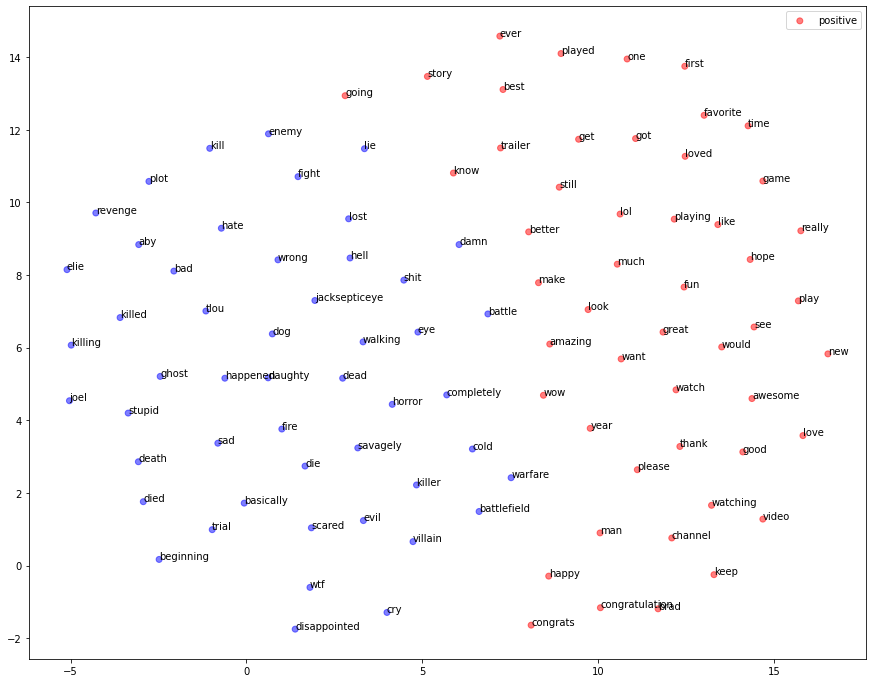

In [68]:
plt.rcParams['figure.figsize'] = 15, 12
plt.scatter(dfumap['Umap_1'], dfumap['Umap_2'],alpha=0.5, c=dfumap['sentiment'].apply(lambda x: colors[x]))
for i, txt in enumerate(dfumap['term']):
    plt.annotate(txt, (dfumap['Umap_1'][i], dfumap['Umap_2'][i]))
plt.legend( labels  = ['positive','negative'])
plt.show()
